In [1]:
import os
from json import load
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import cuda
from chainer import optimizers
from chainer import iterators
from chainer import training
from chainer.training import extensions
from chainer import datasets
from chainer.datasets import TransformDataset
from chainer.datasets import LabeledImageDataset
from functools import partial
from chainercv import transforms

In [2]:
train = LabeledImageDataset('/home/ubuntu/intern-winter-2019/dataset/simple_crop/train_data/train_label.csv',
                            '/home/ubuntu/intern-winter-2019/dataset/simple_crop/train_data/images/',dtype=np.float32)
test = LabeledImageDataset('/home/ubuntu/intern-winter-2019/dataset/simple_crop/test_data/test_label.csv',
                            '/home/ubuntu/intern-winter-2019/dataset/simple_crop/test_data/images/',dtype=np.float32)

def transform(data, train='False'):
    img, label = data
    img = img.copy()
    # Random flip & crop
    if train and label==0:
        img = transforms.random_flip(img, x_random=True)
        img = transforms.random_expand(img, max_ratio=1.5)
        img = transforms.random_crop(img, (26, 26))
    img=np.array(img, dtype=np.float32)
    img=L.model.vision.vgg.prepare(img)

    return img, label

train_dataset = TransformDataset(train, partial(transform, train=True))
test_dataset = TransformDataset(test, partial(transform, train=False))

In [3]:
class Model(chainer.Chain):
    def __init__(self, dim=2):
        super(Model, self).__init__()
        with self.init_scope():
            self.vgg=L.VGG16Layers()
            self.fc1=L.Linear(None, 500)
            self.fc=L.Linear(None, dim)
            
    def __call__(self, x, train=False):
        with chainer.using_config('train', train):
            h=self.vgg(x, layers=['fc7'])['fc7']
            h=self.fc1(h)
            h=F.relu(h)
            h=F.normalize(h)*50
            y=self.fc(h)
        return y
    
class SoftMaxEntoropyLoss(chainer.Chain):
    def __init__(self, model):
        super(SoftMaxEntoropyLoss, self).__init__()
        with self.init_scope():
            self.model = model

    def __call__(self, x, t):
        y = self.model(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        summary = F.classification_summary(y, t, beta = 1.0)
        precision = summary[0]
        recall = summary[1]
        f_value = summary[2]
        precision_dict=dict(('precision_%d' % i, val) for i, val in enumerate(summary[0]))
        recall_dict=dict(('recall_%d' % i, val) for i, val in enumerate(summary[1]))
        f_value_dict=dict(('f_value_%d' % i, val) for i, val in enumerate(summary[2]))
        main_dict={'loss':loss, 'accuracy':accuracy}
        main_dict.update(precision_dict)
        main_dict.update(recall_dict)
        main_dict.update(f_value_dict)
        chainer.report(main_dict, self)
        return loss

In [4]:
# VGG16の初期化 modelの作成
vgg = L.VGG16Layers()

In [5]:
model=Model()
loss=SoftMaxEntoropyLoss(model)

In [6]:
n_epoch = 10
batchsize = 32
out_dir = './result/'
report_interval = (10, 'iteration')

train_iter = iterators.MultithreadIterator\
(train_dataset, batchsize, repeat=True, shuffle=True)
test_iter = iterators.MultithreadIterator\
(test_dataset, batchsize, repeat=False, shuffle=False)

In [7]:
#finetuneなのでMomentumSDG
optimizer = chainer.optimizers.Adam(alpha=1e-3, amsgrad=True)
optimizer.setup(loss)

In [8]:
#device=0でGPU, device=-1でCPU
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [9]:
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 
                                       'iteration', 
                                       'main/loss',
                                       'main/accuracy', 
                                       'main/precision_0', 
                                       'main/precision_1',
                                       'main/recall_0',
                                       'main/recall_1']),
               trigger=report_interval)
trainer.extend(extensions.PlotReport(y_keys='main/loss', trigger=report_interval, file_name='vgg16_loss_plot_dog.png'))
trainer.extend(extensions.PlotReport(y_keys='main/accuracy', trigger=report_interval, file_name='vgg16_accuracy_plot_dog.png'))

In [10]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  main/precision_0  main/precision_1  main/recall_0  main/recall_1
0           10          1.10782     0.8875         nan               0.971875          nan            0.906897       
0           20          0.192397    0.971875       nan               0.971875          nan            1              
0           30          0.278194    0.940625       nan               0.940625          nan            1              
0           40          0.171713    0.975          nan               0.975             nan            1              
0           50          0.138401    0.975          nan               0.975             nan            1              
0           60          0.191672    0.95625        nan               0.95625           nan            1              
1           70          0.116148    0.975          nan               0.975             nan            1              
1           80          0.186165    0.959375       nan    

In [11]:
# save
chainer.serializers.save_npz('./intern2019_finetune_adam.model', model)

In [12]:
X = []
T = []
for x, t in test_dataset:
    X.append(x)
    T.append(t)

X = cp.array(X,dtype=np.float32).reshape(-1, 3, 224, 224)
T = np.array(T,dtype=np.int32)

In [13]:
chance_rate=len(T[T==0]) / len(T)

In [14]:
Y=[]
for i in range(len(X)):
    Y.append([chainer.cuda.to_cpu(model(X[i].reshape(1,3,224,224)).data[0][0]),
              chainer.cuda.to_cpu(model(X[i].reshape(1,3,224,224)).data[0][1])])
Y=np.array(Y)

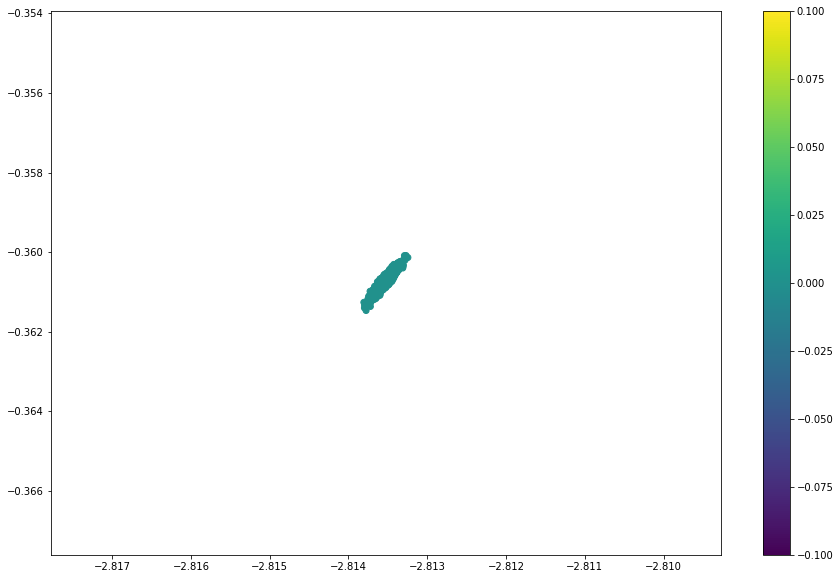

In [22]:
x,y=[0,1],[0,1]
plt.figure(figsize=(15, 10))
plt.scatter(Y[:,0][T==0], Y[:,1][T==0],c=T[T==0])
plt.colorbar()

In [16]:
def get_recall_and_precision(result_array, test_label, distance=1):
    tp,tn,fp,fn=0,0,0,0
    distance_from_origin=np.sqrt(np.sum(result_array**2, axis=1))
    result_label=distance_from_origin<distance
    if len(result_array)!=len(test_label):
        raise ValueError('different dimension')
    else:
        for i in range(len(test_label)):
            if test_label[i]==0 and result_label[i]==True:
                tp+=1
            elif test_label[i]!=0 and result_label[i]==True:
                fp+=1
            elif test_label[i]==0 and result_label[i]!=True:
                fn+=1
            else:
                tn+=1
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    print('distance =',distance)
    print('TP:', tp, ' FP:', fp, ' TN:', tn, 'FN', fn)
    print('recall:', recall)
    print('precision', precision)

In [17]:
get_recall_and_precision(Y,T,distance=9.2)

distance = 9.2
TP: 4907  FP: 475  TN: 0 FN 0
recall: 1.0
precision 0.9117428465254552


In [18]:
def get_recall_and_precision_value(result_array, test_label, distance=1):
    tp,tn,fp,fn=0,0,0,0
    distance_from_origin=np.sqrt(np.sum(result_array**2, axis=1))
    result_label=distance_from_origin<distance
    if len(result_array)!=len(test_label):
        raise ValueError('different dimension')
    else:
        for i in range(len(test_label)):
            if test_label[i]==0 and result_label[i]==True:
                tp+=1
            elif test_label[i]!=0 and result_label[i]==True:
                fp+=1
            elif test_label[i]==0 and result_label[i]!=True:
                fn+=1
            else:
                tn+=1
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    return recall, precision

In [19]:
recall_list,precision_list=[],[]
distance=0.1
while(True):
    distance+=0.1
    tmp_recall, tmp_precision=get_recall_and_precision_value(Y,T,distance=distance)
    if tmp_recall>=1:
        break
    recall_list.append(tmp_recall)
    precision_list.append(tmp_precision)

ZeroDivisionError: division by zero

In [ ]:
p=np.array(recall_list)
r=np.array(precision_list)
plt.plot(p,r)
plt.vlines(0.999,1.01,0,'red')
plt.ylim(chance_rate,1.01)
plt.xlim(0.95,1.001)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
cat=np.random.rand(2,20)
cat[0], cat[1]=cat[0]*-10,cat[1]*10
dog=np.random.rand(2,20)
dog[0], dog[1]=dog[0]*5,cat[1]*-3
origin=np.array([[0],[0]])
x=np.arange(0,)

In [ ]:
cat[1]

In [ ]:
sns.set()
sns.set_style('whitegrid')
fig=plt.figure()
ax=fig.add_subplot(111)
ax.scatter(cat[0],cat[1],label='cat')
ax.scatter(dog[0],dog[1],label='dog')
ax.scatter(origin[0],origin[1],label='origin')
ax.set_xlabel('dog')
ax.set_ylabel('cat')
plt.legend()